In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import glob


In [2]:
def check_overlap(interval, array):
    height = array.shape[0]
    intervals = np.stack([np.tile(interval,(height,1)), array],axis=0)
    anchor =  (intervals[0,:,0] < intervals[1,:,0]).astype(int)
    return intervals[1-anchor,np.arange(height),1] > intervals[anchor,np.arange(height),0]


In [3]:
F1R1_fn = '../data/FASTQ/FADS1_rep8detailed.txt'
F1R2_fn = '../data/FASTQ/FADS1_rep9detailed.txt'

F2R1_fn = '../data/FASTQ/FADS2_rep8detailed.txt'
F2R2_fn = '../data/FASTQ/FADS2_rep11detailed.txt'

F3R1_fn = '../data/FASTQ/FADS3_rep7detailed.txt'
F3R2_fn = '../data/FASTQ/FADS3_rep8detailed.txt'

FnR1_fn = '../data/FASTQ/FEN1_rep11detailed.txt'
FnR2_fn = '../data/FASTQ/FEN1_rep12detailed.txt'

fn_list = [F1R1_fn,F1R2_fn,F2R1_fn,F2R2_fn,
           F3R1_fn,F3R2_fn,FnR1_fn,FnR2_fn]

exp_ids = ['F1R1','F1R2','F2R1','F2R2',
           'F3R1','F3R2','FnR1','FnR2']

In [4]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

In [6]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [7]:
test_peaks = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end']) for fn in sorted(glob.glob('../data/*__sigpeaks.bed')) ]
print(len(test_peaks))
extra_feat = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end'],usecols=[0,1,2]) for fn in ['../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed','../data/DNASE_peaks_replicated.bed'] ]
[ test_peaks.append( feat.loc[ feat['chr'] == 'chr11' ,:] ) for feat in extra_feat ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print(len(test_peaks))
for exp_id, peaks_idx in zip(['F1R1','F1R2','F2R1','F2R2','F3R1','FnR1','k27','DHS'],range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


6
8


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
def plot_hff_cutsites(plot_interval, cutsite_data, peak_data, plot_ids):
    sub_cuts = check_overlap(plot_interval,np.vstack([data['cutsite'].values, 
                                                      (data['cutsite']+1).values]).T)
    sub_cuts = cutsite_data.loc[sub_cuts,:]
    sub_peaks= check_overlap(plot_interval, peak_data.loc[:,('start','end')].values)
    sub_peaks= peak_data.loc[sub_peaks,:]
    
    cut_types  = np.unique(sub_cuts.columns)
    peak_types = np.unique(sub_peaks['exp_id'])
    
    col_dict = { exp_id: color
                 for exp_id, color 
                 in zip(plot_ids, 
                        plt.rcParams['axes.prop_cycle'] \
                          .by_key()['color'][:len(plot_ids)]
                       )
               }
    
    score_max = sub_cuts.loc[:, plot_ids].dropna(axis=1).max().max()
    score_min = sub_cuts.loc[:, plot_ids].dropna(axis=1).min().min()
    score_gap = score_max - \
                score_min
    fig = plt.figure(figsize=(12,6))
    ax  = plt.subplot(111)
    for i, exp_id in enumerate(col_dict.keys()):
        sub_sub_peaks = sub_peaks.loc[ sub_peaks['exp_id'] == exp_id, : ]
        peak_position = score_max + ( ( 0.2+(i*0.05) ) * score_gap )
        for j, row in sub_sub_peaks.iterrows():
            ax.hlines(y=peak_position, 
                      xmin=row['start'], xmax=row['end'],
                      color=col_dict[exp_id])
        if exp_id in cut_types:    
            ax.scatter(sub_cuts['cutsite'],sub_cuts[exp_id],color=col_dict[exp_id],s=8,alpha=0.5)
            
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    custom_lines = [ Line2D([0], [0], color=col_dict[color]) for color in plot_ids ]
    ax.legend(custom_lines, plot_ids)
    return ax
            

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


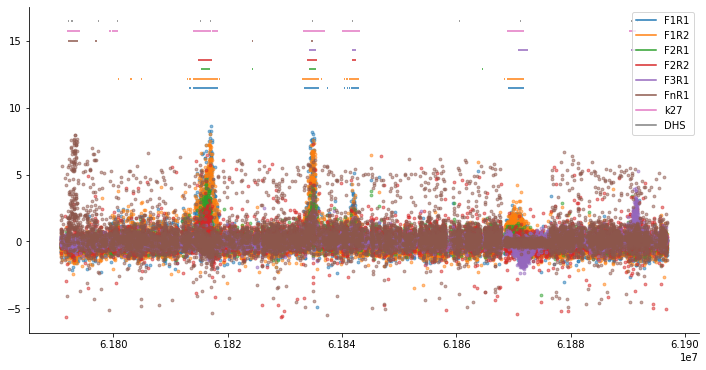

In [9]:
plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','FnR1','k27','DHS'])


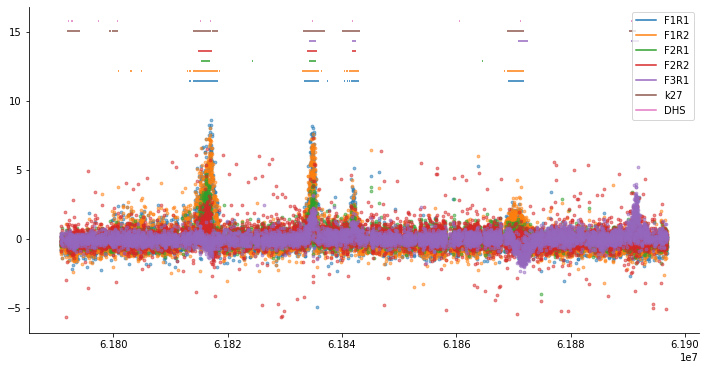

In [10]:
plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','k27','DHS'])


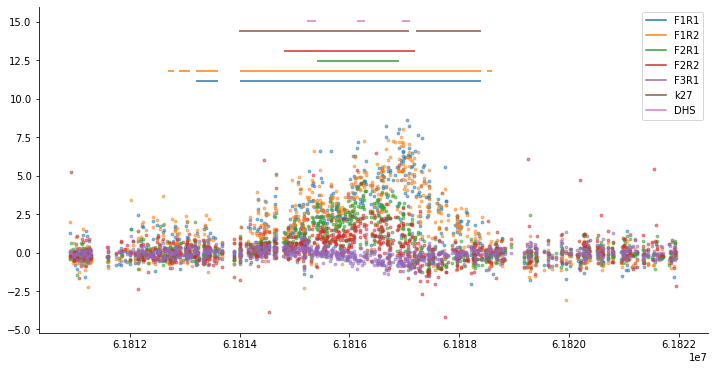

In [11]:
plot_hff_cutsites(np.array([[61810908,61822034]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','k27','DHS'])


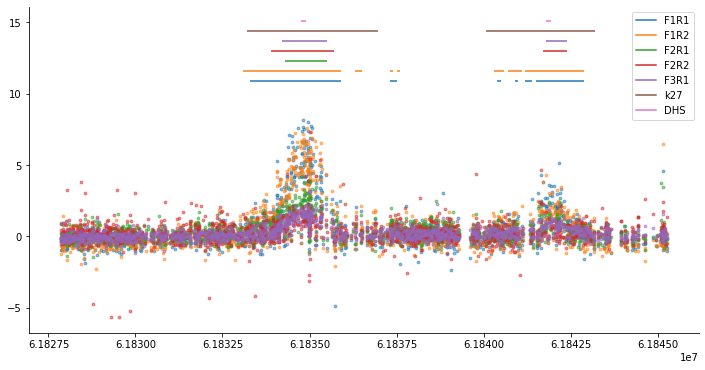

In [12]:
plot_hff_cutsites(np.array([[61827852,61845270]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','k27','DHS'])


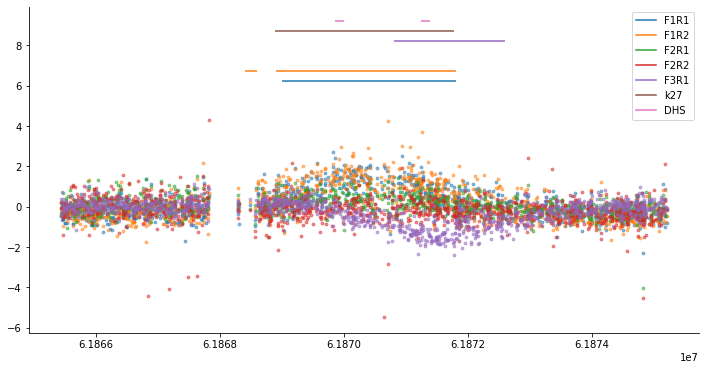

In [13]:
plot_hff_cutsites(np.array([[61865430,61875290]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','k27','DHS'])
